In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd '/content/drive/My Drive'

Mounted at /content/drive/
/content/drive/My Drive


### Required Libraries

In [ ]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM

import torch
%matplotlib inline

import h5py
import PIL.Image as Image
import numpy as np
import os
import glob
import scipy
#from image import *
#from model import CANNet
import torch
from torch.autograd import Variable

from sklearn.metrics import mean_squared_error,mean_absolute_error

from torchvision import transforms

import sys
import os

import warnings
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import argparse
import json
import cv2

import time


<ipython-input-2-936d572be30e>:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


### Helper functions:

#### Following function helps in creation of batch data and increasing images by cropping and mirroring existing images:

image.py

In [ ]:
import random
import os
from PIL import Image
import numpy as np
import h5py
import cv2

def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground_truth')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path,'r')
    target = np.asarray(gt_file['density'])
    if train:
        ratio = 0.5
        crop_size = (int(img.size[0]*ratio),int(img.size[1]*ratio))
        rdn_value = random.random()
        if rdn_value<0.25:
            dx = 0
            dy = 0
        elif rdn_value<0.5:
            dx = int(img.size[0]*ratio)
            dy = 0
        elif rdn_value<0.75:
            dx = 0
            dy = int(img.size[1]*ratio)
        else:
            dx = int(img.size[0]*ratio)
            dy = int(img.size[1]*ratio)

        img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
        target = target[dy:(crop_size[1]+dy),dx:(crop_size[0]+dx)]
        if random.random()>0.8:
            target = np.fliplr(target)
            img = img.transpose(Image.FLIP_LEFT_RIGHT)

    target = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64

    return img,target

#### Function for groundtruth creation:

make_dataset.py

In [ ]:
import  h5py
import  scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib import cm as CM
#from image import *

# root is the path to ShanghaiTech dataset
root='ShanghaiTech_Crowd_Counting_Dataset'

part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_B_train,part_B_test]


img_paths  = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

for  img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_118.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_343.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_83.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_235.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_165.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_59.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_287.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_60.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_61.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_346.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_128.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_213.jpg
ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_d

#### Function to save checkpoints during training:

utils.py

In [ ]:
import h5py
import torch
import shutil
import numpy as np

def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')  

#### Function for batch dataset creation:

dataset.py

In [ ]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
#from image import *
import torchvision.transforms.functional as F

class listDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, seen=0, batch_size=1, num_workers=4):
        random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.seen = seen
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        
    def __len__(self):
        return self.nSamples
    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        if self.transform is not None:
            img = self.transform(img)
        return img,target

#### Function to create json file containing list of paths for train data and validation data:

create_json.py

In [ ]:
train_paths = img_paths[:400]
test_paths = img_paths[400:]
random.shuffle(train_paths)
random.shuffle(test_paths)

In [ ]:
import json
from os.path import join
import glob


if __name__ == '__main__':
    # path to folder that contains images
    #img_folder = 'ShanghaiTech_Crowd_Counting_Dataset_sample/part_B_final/test_data/images'

    # path to the final json file
    output_json = 'val_shanghai.json'

    img_list = train_paths[:20]

    # for img_path in glob.glob(join(img_folder,'*.jpg')):
    #     img_list.append(img_path)

    with open(output_json,'w') as f:
        json.dump(img_list,f)

### CANNet Model

model.py

In [ ]:
import torch.nn as nn
import torch
from torch.nn import functional as F
from torchvision import models

class ContextualModule(nn.Module):
    def __init__(self, features, out_features=512, sizes=(1, 2, 3, 6)):
        super(ContextualModule, self).__init__()
        self.scales = []
        self.scales = nn.ModuleList([self._make_scale(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * 2, out_features, kernel_size=1)
        self.relu = nn.ReLU()
        self.weight_net = nn.Conv2d(features,features,kernel_size=1)

    def __make_weight(self,feature,scale_feature):
        weight_feature = feature - scale_feature
        return F.sigmoid(self.weight_net(weight_feature))

    def _make_scale(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        multi_scales = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.scales]
        weights = [self.__make_weight(feats,scale_feature) for scale_feature in multi_scales]
        overall_features = [(multi_scales[0]*weights[0]+multi_scales[1]*weights[1]+multi_scales[2]*weights[2]+multi_scales[3]*weights[3])/(weights[0]+weights[1]+weights[2]+weights[3])]+ [feats]
        bottle = self.bottleneck(torch.cat(overall_features, 1))
        return self.relu(bottle)

class CANNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CANNet, self).__init__()
        self.seen = 0
        self.context = ContextualModule(512, 512)
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,batch_norm=True, dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                #list(self.frontend.state_dict().items()[i][1].data[:]) = list(mod.state_dict().items()[i][1].data[:])
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]

    def forward(self,x):
        x = self.frontend(x)
        print(x.shape)
        x = self.context(x)
        print(x.shape)
        x = self.backend(x)
        print(x.shape)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

#### Understanding layers and shapes at each stage:

In [ ]:
model = CANNet()

model = model.cuda()

checkpoint = torch.load('model_best.pth.tar')

model.load_state_dict(checkpoint['state_dict'])

model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 295MB/s]


CANNet(
  (context): ContextualModule(
    (scales): ModuleList(
      (0): Sequential(
        (0): AdaptiveAvgPool2d(output_size=(1, 1))
        (1): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): Sequential(
        (0): AdaptiveAvgPool2d(output_size=(2, 2))
        (1): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (2): Sequential(
        (0): AdaptiveAvgPool2d(output_size=(3, 3))
        (1): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (3): Sequential(
        (0): AdaptiveAvgPool2d(output_size=(6, 6))
        (1): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (bottleneck): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (weight_net): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
  )
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
 

#### Training on ShanghaiTech Part B Dataset

train.py

In [ ]:
best_prec1 = 1e6

lr = 1e-4
batch_size    = 16
decay         = 5*1e-4
start_epoch   = 0
epochs = 100
workers = 4
seed = int(time.time())
print_freq = 4

train_json = "train_shanghai.json"
val_json = "val_shanghai.json"

def main():

    global args,best_prec1

    best_prec1 = 1e6

    #args = parser.parse_args()
    lr = 1e-4
    batch_size    = 16
    decay         = 5*1e-4
    start_epoch   = 0
    epochs = 100
    workers = 4
    seed = int(time.time())
    print_freq = 4

    with open(train_json, 'r') as outfile:
        train_list = json.load(outfile)
    with open(val_json, 'r') as outfile:
        val_list = json.load(outfile)

    torch.cuda.manual_seed(seed)

    model = CANNet()

    model = model.cuda()

    criterion = nn.MSELoss(size_average=False).cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr,
                                    weight_decay=decay)

    for epoch in range(start_epoch, epochs):
        train(train_list, model, criterion, optimizer, epoch)
        prec1 = validate(val_list, model, criterion)

        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        print(' * best MAE {mae:.3f} '
              .format(mae=best_prec1))
        save_checkpoint({
            'state_dict': model.state_dict(),
        }, is_best)

def train(train_list, model, criterion, optimizer, epoch):

    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()

    train_loader = torch.utils.data.DataLoader(
        listDataset(train_list,
                       shuffle=True,
                       transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ]),
                       train=True,
                       seen=model.seen,
                       batch_size=batch_size,
                       num_workers=workers),
        batch_size=batch_size)
    print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), lr))

    model.train()
    end = time.time()

    for i,(img, target)in enumerate(train_loader):
        data_time.update(time.time() - end)

        img = img.cuda()
        img = Variable(img)
        output = model(img)[:,0,:,:]

        target = target.type(torch.FloatTensor).cuda()
        target = Variable(target)

        loss = criterion(output, target)

        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  .format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))

def validate(val_list, model, criterion):
    print ('begin val')
    val_loader = torch.utils.data.DataLoader(
    listDataset(val_list,
                   shuffle=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ]),  train=False),
    batch_size=1)

    model.eval()

    mae = 0

    for i,(img, target) in enumerate(val_loader):
        h,w = img.shape[2:4]
        h_d = int(h/2)
        w_d = int(w/2)
        img_1 = Variable(img[:,:,:h_d,:w_d].cuda())
        img_2 = Variable(img[:,:,:h_d,w_d:].cuda())
        img_3 = Variable(img[:,:,h_d:,:w_d].cuda())
        img_4 = Variable(img[:,:,h_d:,w_d:].cuda())
        density_1 = model(img_1).data.cpu().numpy()
        density_2 = model(img_2).data.cpu().numpy()
        density_3 = model(img_3).data.cpu().numpy()
        density_4 = model(img_4).data.cpu().numpy()

        pred_sum = density_1.sum()+density_2.sum()+density_3.sum()+density_4.sum()

        mae += abs(pred_sum-target.sum())

    mae = mae/len(val_loader)
    print(' * MAE {mae:.3f} '
              .format(mae=mae))

    return mae

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

if __name__ == '__main__':
    main()

epoch 0, processed 0 samples, lr 0.0001000000


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: [0][0/24]	Time 4.255 (4.255)	Data 3.638 (3.638)	Loss 155.3587 (155.3587)	
Epoch: [0][4/24]	Time 4.271 (4.187)	Data 3.695 (3.616)	Loss 53.8815 (141.8704)	
Epoch: [0][8/24]	Time 3.697 (4.110)	Data 3.141 (3.543)	Loss 28.2273 (101.2954)	
Epoch: [0][12/24]	Time 4.068 (4.138)	Data 3.492 (3.569)	Loss 31.0592 (88.5624)	
Epoch: [0][16/24]	Time 4.050 (4.127)	Data 3.470 (3.556)	Loss 12.3583 (73.0374)	
Epoch: [0][20/24]	Time 3.749 (4.118)	Data 3.174 (3.547)	Loss 40.3717 (73.0576)	
begin val
 * MAE 75.560 
 * best MAE 75.560 
epoch 1, processed 380 samples, lr 0.0001000000
Epoch: [1][0/24]	Time 1.010 (1.010)	Data 0.456 (0.456)	Loss 32.1029 (32.1029)	
Epoch: [1][4/24]	Time 1.953 (1.761)	Data 0.459 (0.533)	Loss 14.5630 (25.0055)	
Epoch: [1][8/24]	Time 1.976 (1.853)	Data 0.650 (0.524)	Loss 21.2055 (33.4168)	
Epoch: [1][12/24]	Time 1.953 (1.886)	Data 0.445 (0.521)	Loss 18.1938 (31.6249)	
Epoch: [1][16/24]	Time 1.913 (1.897)	Data 0.646 (0.529)	Loss 8.5227 (27.1078)	
Epoch: [1][20/24]	Time 1.919 (

test.py

In [ ]:
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

# the folder contains all the test images
img_folder='ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data/images'
img_paths=[]

for img_path in glob.glob(os.path.join(img_folder, '*.jpg')):
    img_paths.append(img_path)

model = CANNet()

model = model.cuda()

checkpoint = torch.load('model_best.pth.tar')

model.load_state_dict(checkpoint['state_dict'])

model.eval()

pred= []
gt = []

for i in range(len(img_paths)):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    img = img.unsqueeze(0)
    h,w = img.shape[2:4]
    h_d = int(h/2)
    w_d = int(w/2)
    img_1 = Variable(img[:,:,:h_d,:w_d].cuda())
    img_2 = Variable(img[:,:,:h_d,w_d:].cuda())
    img_3 = Variable(img[:,:,h_d:,:w_d].cuda())
    img_4 = Variable(img[:,:,h_d:,w_d:].cuda())
    density_1 = model(img_1).data.cpu().numpy()
    density_2 = model(img_2).data.cpu().numpy()
    density_3 = model(img_3).data.cpu().numpy()
    density_4 = model(img_4).data.cpu().numpy()

    pure_name = os.path.splitext(os.path.basename(img_paths[i]))[0]
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    pred_sum = density_1.sum()+density_2.sum()+density_3.sum()+density_4.sum()
    pred.append(pred_sum)
    gt.append(np.sum(groundtruth))

mae = mean_absolute_error(pred,gt)
rmse = np.sqrt(mean_squared_error(pred,gt))

print('MAE: ',mae)
print('RMSE: ',rmse)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


MAE:  9.867568035668974
RMSE:  15.188297237015576


### Results:

In [ ]:
def predictions(img):
  transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),])
  gt_file = h5py.File(img.replace('.jpg','.h5').replace('images','ground_truth'),'r')
  groundtruth = np.asarray(gt_file['density'])

  model = CANNet()

  model = model.cuda()

  checkpoint = torch.load('model_best.pth.tar')

  model.load_state_dict(checkpoint['state_dict'])

  model.eval()
  transformed_img = transform(Image.open(img).convert('RGB')).cuda()
  transformed_img = transformed_img.unsqueeze(0)
  pred_img = model(transformed_img).data.cpu().numpy().squeeze()

  fig, ax = plt.subplots(1,3, figsize = (25,10))

  ax[0].imshow(Image.open(img))
  ax[0].set_title('Original Image')
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[1].imshow(groundtruth,cmap=CM.jet)
  ax[1].set_title('Groundtruth')
  ax[1].set_xticks([])
  ax[1].set_yticks([])
  ax[2].imshow(pred_img,cmap=CM.jet)
  ax[2].set_title('Prediction')
  ax[2].set_xticks([])
  ax[2].set_yticks([])

In [ ]:
img =  '/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data/images/IMG_1.jpg'

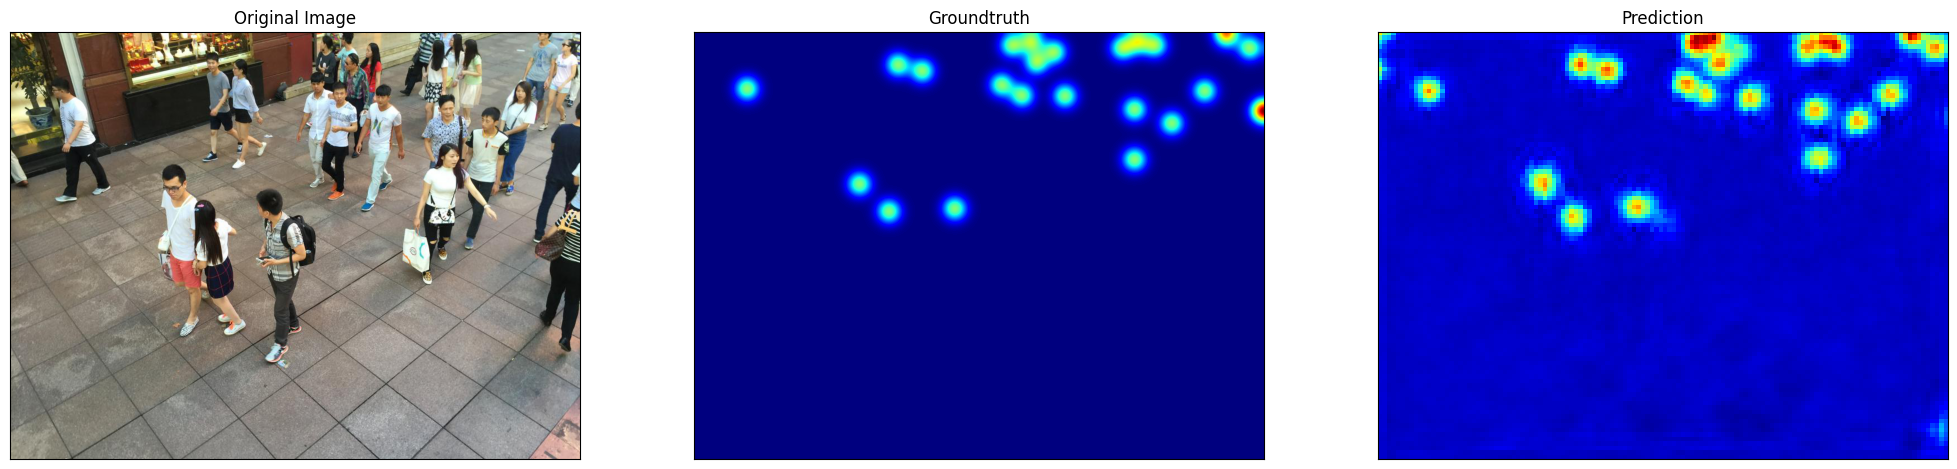

In [ ]:
predictions(img)

## Working on Penguin dataset:

In [ ]:
root='Penguins_sample'

part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_B_train]


img_paths  = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.JPG')):
        img_paths.append(img_path)

In [ ]:
img_paths = sorted(img_paths)

In [ ]:
img_paths[:61]

['Penguins_sample/part_B_final/train_data/images/BAILa2014a_000335.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000373.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000419.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000575.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000636.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000741.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000765.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000768.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000772.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000791.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000819.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000846.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000882.JPG',
 'Penguins_sample/part_B_final/train_data/images/BA

In [ ]:
import scipy.io
mat1 = scipy.io.loadmat('/content/MAIVc.mat')

#### Groundtruth creation:

In [ ]:
for  img_path in img_paths[109:120]:
    print(img_path)
    #mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img = plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    #gt = mat["image_info"][0,0][0,0][0]
    ind = [x[0] for x,y in mat1['dots'][0]].index(img_path[-21:-4])
    gt = mat1['dots'][0][ind][1][0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.JPG','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

Penguins_sample/part_B_final/train_data/images/MAIVc2013b_000053.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_000904.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_001153.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_001306.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_003722.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_003762.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_003839.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_003881.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_003905.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_004000.JPG
Penguins_sample/part_B_final/train_data/images/MAIVc2013b_004003.JPG


In [ ]:
import random
train_list = img_paths[:60]
random.shuffle(sup)

In [ ]:
train_list

['Penguins_sample/part_B_final/train_data/images/GEORa2013b_003656.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000741.JPG',
 'Penguins_sample/part_B_final/train_data/images/GEORa2013b_000497.JPG',
 'Penguins_sample/part_B_final/train_data/images/DAMOa2014a_000008.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000819.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000575.JPG',
 'Penguins_sample/part_B_final/train_data/images/GEORa2013a_000041.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_000768.JPG',
 'Penguins_sample/part_B_final/train_data/images/DAMOa2014a_000352.JPG',
 'Penguins_sample/part_B_final/train_data/images/BAILa2014a_004886.JPG',
 'Penguins_sample/part_B_final/train_data/images/DAMOa2014a_000171.JPG',
 'Penguins_sample/part_B_final/train_data/images/DAMOa2014a_000083.JPG',
 'Penguins_sample/part_B_final/train_data/images/DAMOa2014a_000395.JPG',
 'Penguins_sample/part_B_final/train_data/images/DA

#### Creating json of image paths list:

In [ ]:
import json
from os.path import join
import glob


if __name__ == '__main__':
    # path to the final json file
    output_json = 'val_peng.json'

    img_list = train_list[:12]

    with open(output_json,'w') as f:
        json.dump(img_list,f)

#### Training:

In [ ]:
train_json = "train_peng.json"
val_json = "val_peng.json"

def main():

    global args,best_prec1

    best_prec1 = 1e6

    #args = parser.parse_args()
    lr = 1e-4
    batch_size    = 4
    decay         = 5*1e-4
    start_epoch   = 0
    epochs = 50
    workers = 4
    seed = int(time.time())
    print_freq = 4

    with open(train_json, 'r') as outfile:
        train_list = json.load(outfile)
    with open(val_json, 'r') as outfile:
        val_list = json.load(outfile)

    torch.cuda.manual_seed(seed)

    model = CANNet()

    model = model.cuda()

    criterion = nn.MSELoss(size_average=False).cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr,
                                    weight_decay=decay)

    for epoch in range(start_epoch, epochs):
        train(train_list, model, criterion, optimizer, epoch)
        prec1 = validate(val_list, model, criterion)

        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        print(' * best MAE {mae:.3f} '
              .format(mae=best_prec1))
        save_checkpoint({
            'state_dict': model.state_dict(),
        }, is_best)

def train(train_list, model, criterion, optimizer, epoch):

    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()

    train_loader = torch.utils.data.DataLoader(
        listDataset(train_list,
                       shuffle=True,
                       transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ]),
                       train=True,
                       seen=model.seen,
                       batch_size=batch_size,
                       num_workers=workers),
        batch_size=batch_size)
    print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), lr))

    model.train()
    end = time.time()

    for i,(img, target)in enumerate(train_loader):
        data_time.update(time.time() - end)

        img = img.cuda()
        img = Variable(img)
        output = model(img)[:,0,:,:]

        target = target.type(torch.FloatTensor).cuda()
        target = Variable(target)

        loss = criterion(output, target)

        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  .format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))

def validate(val_list, model, criterion):
    print ('begin val')
    val_loader = torch.utils.data.DataLoader(
    listDataset(val_list,
                   shuffle=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ]),  train=False),
    batch_size=1)

    model.eval()

    mae = 0

    for i,(img, target) in enumerate(val_loader):
        h,w = img.shape[2:4]
        h_d = int(h/2)
        w_d = int(w/2)
        img_1 = Variable(img[:,:,:h_d,:w_d].cuda())
        img_2 = Variable(img[:,:,:h_d,w_d:].cuda())
        img_3 = Variable(img[:,:,h_d:,:w_d].cuda())
        img_4 = Variable(img[:,:,h_d:,w_d:].cuda())
        density_1 = model(img_1).data.cpu().numpy()
        density_2 = model(img_2).data.cpu().numpy()
        density_3 = model(img_3).data.cpu().numpy()
        density_4 = model(img_4).data.cpu().numpy()

        pred_sum = density_1.sum()+density_2.sum()+density_3.sum()+density_4.sum()

        mae += abs(pred_sum-target.sum())

    mae = mae/len(val_loader)
    print(' * MAE {mae:.3f} '
              .format(mae=mae))

    return mae

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

if __name__ == '__main__':
    main()

epoch 0, processed 0 samples, lr 0.0001000000
Epoch: [0][0/12]	Time 2.730 (2.730)	Data 0.414 (0.414)	Loss 147.5949 (147.5949)	
Epoch: [0][4/12]	Time 2.321 (2.230)	Data 0.397 (0.484)	Loss 34.7032 (150.3387)	
Epoch: [0][8/12]	Time 2.360 (2.281)	Data 0.419 (0.448)	Loss 14.7946 (94.8243)	
begin val
 * MAE 21.599 
 * best MAE 21.599 
epoch 1, processed 48 samples, lr 0.0001000000
Epoch: [1][0/12]	Time 0.996 (0.996)	Data 0.369 (0.369)	Loss 4.9907 (4.9907)	
Epoch: [1][4/12]	Time 2.310 (2.064)	Data 0.523 (0.445)	Loss 3.0500 (4.1950)	
Epoch: [1][8/12]	Time 2.305 (2.169)	Data 0.385 (0.424)	Loss 3.0400 (3.4188)	
begin val
 * MAE 30.314 
 * best MAE 21.599 
epoch 2, processed 96 samples, lr 0.0001000000
Epoch: [2][0/12]	Time 1.009 (1.009)	Data 0.398 (0.398)	Loss 1.2994 (1.2994)	
Epoch: [2][4/12]	Time 2.291 (2.029)	Data 0.379 (0.369)	Loss 1.6222 (1.4463)	
Epoch: [2][8/12]	Time 2.297 (2.144)	Data 0.435 (0.428)	Loss 0.7130 (1.0966)	
begin val
 * MAE 58.761 
 * best MAE 21.599 
epoch 3, processed 144 

#### Results:

In [ ]:
def penguin_predictions(img):
  transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),])
  gt_file = h5py.File(img.replace('.JPG','.h5').replace('images','ground_truth'),'r')
  groundtruth = np.asarray(gt_file['density'])
  
  model = CANNet()

  model = model.cuda()

  checkpoint = torch.load('pen_model_best.pth.tar')

  model.load_state_dict(checkpoint['state_dict'])

  model.eval()
  transformed_img = transform(Image.open(img).convert('RGB')).cuda()
  transformed_img = transformed_img.unsqueeze(0)
  pred_img = model(transformed_img).data.cpu().numpy().squeeze()

  fig, ax = plt.subplots(1,3, figsize = (25,10))

  ax[0].imshow(Image.open(img))
  ax[0].set_title('Original Image')
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[1].imshow(groundtruth,cmap=CM.jet)
  ax[1].set_title('Groundtruth')
  ax[1].set_xticks([])
  ax[1].set_yticks([])
  ax[2].imshow(pred_img,cmap=CM.jet)
  ax[2].set_title('Prediction')
  ax[2].set_xticks([])
  ax[2].set_yticks([])

In [ ]:
img = '/content/drive/MyDrive/Penguins_sample (1)/part_B_final/train_data/images/BAILa2014a_004059.JPG'

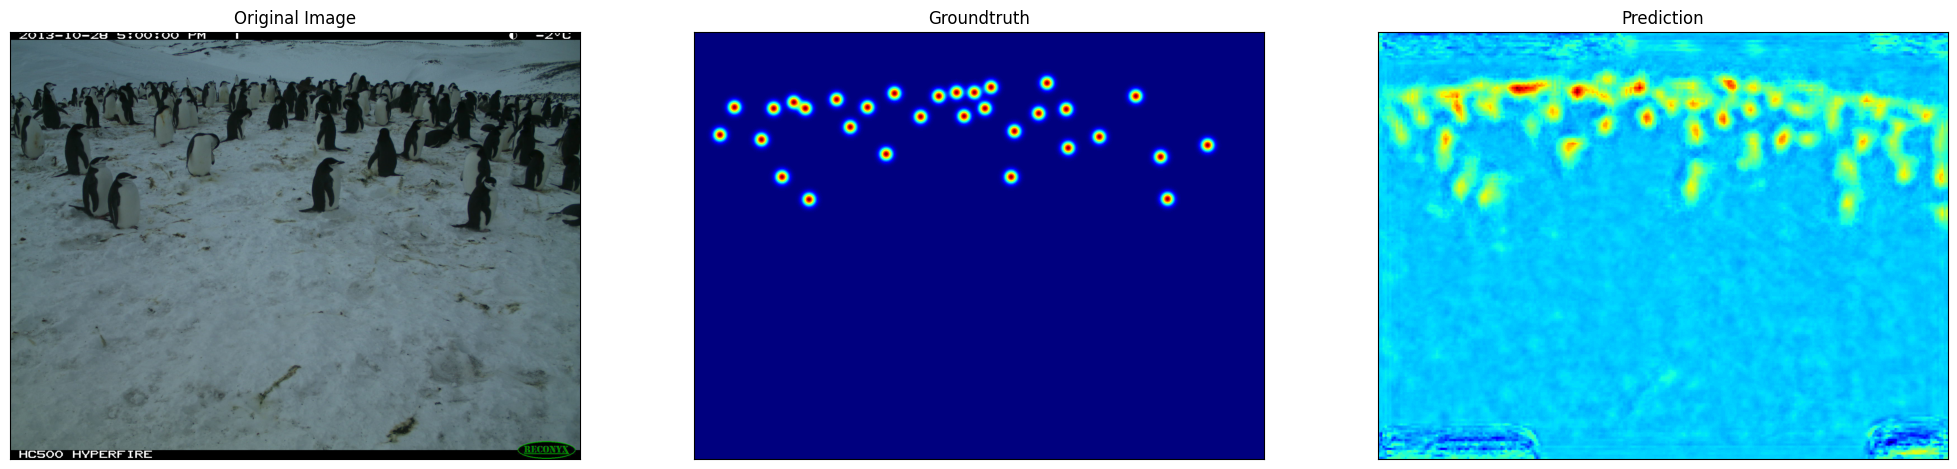

In [ ]:
penguin_predictions(img)

In [ ]:
img = '/content/drive/MyDrive/Penguins_sample (1)/part_B_final/train_data/images/HALFc2013a_000175.JPG'

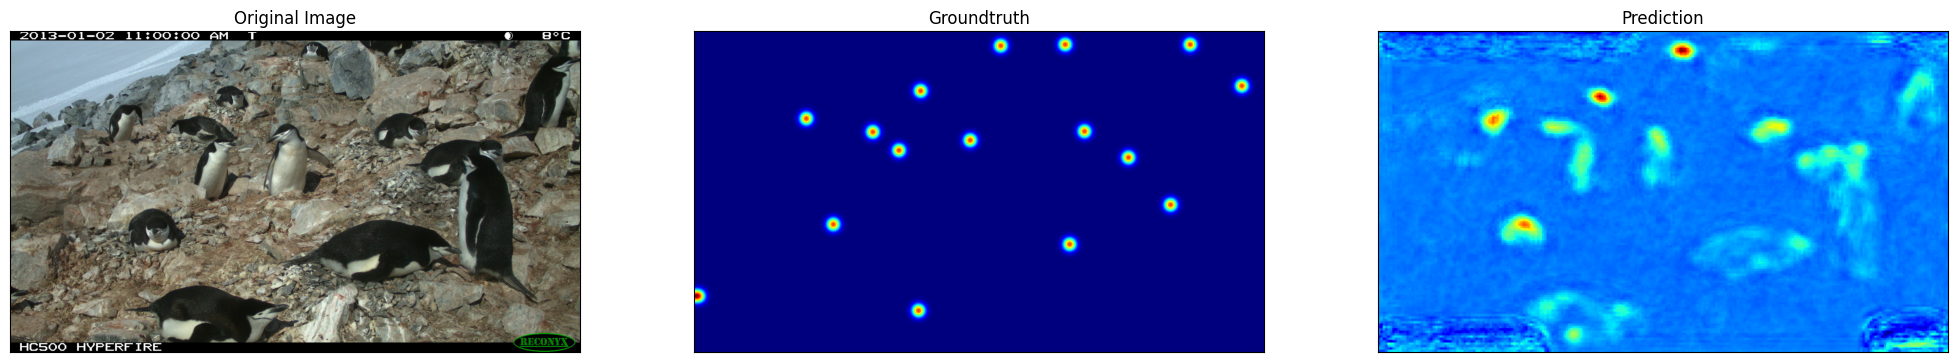

In [ ]:
penguin_predictions(img)